# Case Study 2 : Hospital Readmission

Submitted by:

- Ravi Sivaraman
- Balaji Avvaru
- Apurv Mittal

The code for importing the data is combined with the inital loading of various analysis and visualization packages below.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import VarianceThreshold
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [2]:
# read diabetic csv files
diabetic_df = pd.read_csv('/Users/ravis/Downloads/dataset_diabetes/diabetic_data.csv')
#diabetic_df = pd.read_csv('diabetic_data.csv')
diabetic_df.shape

(101766, 50)

In [3]:
# Validate null values in the csv file
diabetic_df.isnull().sum().sum()

0

There are no null values in the dataset, but null values are coded as ?, first replace observations value ? with nan

In [4]:
# replace ? with nan
diabetic_df = diabetic_df.replace("?",np.nan)

In [5]:
diabetic_df.encounter_id.nunique()

101766

In [6]:
# drop encounter_id variable as it is unique id - https://www.hindawi.com/journals/bmri/2014/781670/tab1/
diabetic_df.drop(['encounter_id'], inplace=True, axis=1)

In [7]:
# drop patient_nbr Unique identifier of a patient - https://www.hindawi.com/journals/bmri/2014/781670/tab1/
diabetic_df.drop(['patient_nbr'], inplace=True, axis=1)

In [8]:
# Validate null values in the csv file
print(diabetic_df.isnull().sum())
# print columns with null values
missing_data_columns = diabetic_df.columns[diabetic_df.isnull().any()]
print("\n\nColumns with null values")
print("************************")
missing_data_columns

race                         2273
gender                          0
age                             0
weight                      98569
admission_type_id               0
discharge_disposition_id        0
admission_source_id             0
time_in_hospital                0
payer_code                  40256
medical_specialty           49949
num_lab_procedures              0
num_procedures                  0
num_medications                 0
number_outpatient               0
number_emergency                0
number_inpatient                0
diag_1                         21
diag_2                        358
diag_3                       1423
number_diagnoses                0
max_glu_serum                   0
A1Cresult                       0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide     

Index(['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3'],
      dtype='object')

In [9]:
# percentage of missing values in each variable
diabetic_df[missing_data_columns].isnull().sum()/len(diabetic_df)*100

race                  2.233555
weight               96.858479
payer_code           39.557416
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
dtype: float64

In [10]:
diabetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      99493 non-null   object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    3197 non-null    object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   payer_code                61510 non-null   object
 9   medical_specialty         51817 non-null   object
 10  num_lab_procedures        101766 non-null  int64 
 11  num_procedures            101766 non-null  int64 
 12  num_medications           101766 non-null  int64 
 13  number_outpatient         101766 non-null  int64 
 14  numb

##### Target variable

In [11]:
# Convert target variable to a categorical 
diabetic_df['readmitted'].value_counts()

NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

There are three different values for target variable. We decided to reduce these values to two based on whether readmitted ot not (0 means not admitted and 1 means admitted) 

In [12]:
diabetic_df['readmitted'] = diabetic_df['readmitted'].replace('>30', 0)
diabetic_df['readmitted'] = diabetic_df['readmitted'].replace('<30', 1)
diabetic_df['readmitted'] = diabetic_df['readmitted'].replace('NO', 0)

In [13]:
diabetic_df['readmitted'].value_counts()

0    90409
1    11357
Name: readmitted, dtype: int64

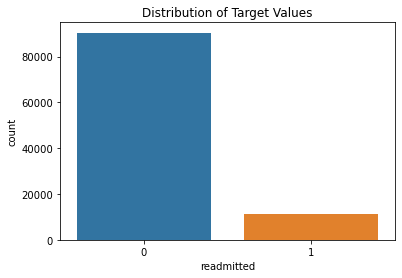

In [14]:
sns.countplot(x = "readmitted", data = diabetic_df)
plt.title("Distribution of Target Values")
plt.show()

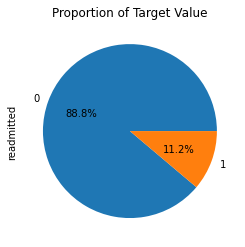

In [15]:
# Pie chart
diabetic_df.readmitted.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion of Target Value")
plt.show()

These two diagrams show us that our target variable is not balanced.

##### Variables with Missing data

In [16]:
missing_data_columns

Index(['race', 'weight', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2',
       'diag_3'],
      dtype='object')

#### Analyse Variables

In [17]:
data_reduced = diabetic_df[["race", "gender", "age", "weight"]]

In [18]:
# Gender
data_reduced["gender"] = [1 if x=="Male" else 0 for x in data_reduced["gender"]]

In [19]:
# race
data_reduced['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [20]:
# replacing the missing race values with Caucasian
data_reduced['race'] = data_reduced['race'].fillna("Caucasian")

In [21]:
# One hot encoding Race
data_reduced_race = pd.get_dummies(data_reduced.race, prefix='race')
data_reduced_race=data_reduced_race.astype(float)

In [22]:
# convert the age in numeric
age_num = {'[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35, '[40-50)': 45, 
           '[50-60)': 55, '[70-80)': 75, '[60-70)': 65, '[80-90)': 85, '[90-100)': 95 }

data_reduced["age"].replace(age_num, inplace=True)
print(data_reduced["age"].value_counts())

75    26068
65    22483
55    17256
85    17197
45     9685
35     3775
95     2793
25     1657
15      691
5       161
Name: age, dtype: int64


In [23]:
#Concat
# creating DF of one hot encoded values
data = pd.concat([data_reduced,data_reduced_race],axis=1)


In [24]:
# drop race as its duplicate now
data=data.drop(["race"], axis=1)


In [25]:
# checking values for weight
print("Weight values",data['weight'].value_counts())

# replacinf Weight values with average of the range

data['weight'] = data['weight'].replace('[0-25)', np.nan)
data['weight'] = data['weight'].replace('[25-50)', 37.5)
data['weight'] = data['weight'].replace('[50-75)', 62.5)
data['weight'] = data['weight'].replace('[75-100)', 87.5)
data['weight'] = data['weight'].replace('[100-125)', 112.5)
data['weight'] = data['weight'].replace('[125-150)', 137.5)
data['weight'] = data['weight'].replace('[150-175)', 162.5)
data['weight'] = data['weight'].replace('[175-200)', 187.5)
data['weight'] = data['weight'].replace('>200', 250)

Weight values [75-100)     1336
[50-75)       897
[100-125)     625
[125-150)     145
[25-50)        97
[0-25)         48
[150-175)      35
[175-200)      11
>200            3
Name: weight, dtype: int64


In [26]:
# assigning all missing data rows to test data set
test_data = data[data["weight"].isna()]

In [27]:
# running regression to predict missing weight values
df_wona = data.dropna(axis=0)

y_train = df_wona["weight"]
X_train = df_wona.drop("weight", axis=1)
X_test = test_data.drop("weight", axis=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# reference: https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e

In [28]:
X_test['weight'] = y_pred
df_new = pd.concat([df_wona, X_test], axis=0)
df_new.sort_index(axis = 0)
diabetic_df.drop(['weight','age', 'race', 'gender'], axis =1, inplace=True)
diabetic_df = pd.concat([diabetic_df, df_new], axis=1)

In [29]:
# Discharge Disposition ID
diabetic_df['discharge_disposition_id'].describe()

count    101766.000000
mean          3.715642
std           5.280166
min           1.000000
25%           1.000000
50%           1.000000
75%           4.000000
max          28.000000
Name: discharge_disposition_id, dtype: float64

There are 30 distinct values. This variable will tell whether the patient discharged to home or any other facility etc

- 1	Discharged to home 
- 2	Discharged/transferred to another short term hospital
- 3	Discharged/transferred to SNF
- 4	Discharged/transferred to ICF
- 5	Discharged/transferred to another type of inpatient care institution
- 6	Discharged/transferred to home with home health service
- 7	Left AMA
- 8	Discharged/transferred to home under care of Home IV provider
- 9	Admitted as an inpatient to this hospital
- 10	Neonate discharged to another hospital for neonatal aftercare
- 11	Expired
- 12	Still patient or expected to return for outpatient services
- 13	Hospice / home
- 14	Hospice / medical facility
- 15	Discharged/transferred within this institution to Medicare approved swing bed
- 16	Discharged/transferred/referred another institution for outpatient services
- 17	Discharged/transferred/referred to this institution for outpatient services
- 18	NULL
- 19	Expired at home. Medicaid only, hospice.
- 20	Expired in a medical facility. Medicaid only, hospice.
- 21	Expired, place unknown. Medicaid only, hospice.
- 22	Discharged/transferred to another rehab fac including rehab units of a hospital .
- 23	Discharged/transferred to a long term care hospital.
- 24	Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.
- 25	Not Mapped
- 26	Unknown/Invalid
- 30	Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere
- 27	Discharged/transferred to a federal health care facility.
- 28	Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital
- 29	Discharged/transferred to a Critical Access Hospital (CAH).

In [30]:
diabetic_df['discharge_disposition_id'].value_counts()

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

we remove observations where the discharge disposition is related to death since these will not add to the possibility of being readmitted.

In [31]:
indexNames = diabetic_df[diabetic_df['discharge_disposition_id'].isin([11,19,20,21])].index
diabetic_df.drop(indexNames, inplace=True)

We can make all these observations with respect to discharge_disposition_id into two different categories Home and other. The categories  18-NULL, 25-Not Mapped and 26-Unknown/Invalid are comes under NULL values. We need imputation for these categories. We decided to combine these categories with other categories.

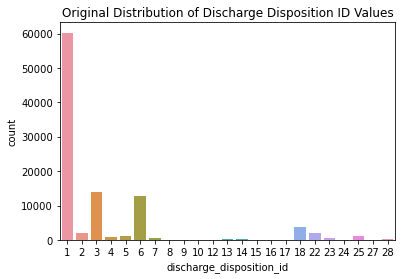

In [32]:
sns.countplot(x ="discharge_disposition_id", data = diabetic_df)
plt.title("Original Distribution of Discharge Disposition ID Values")
plt.show()

In [33]:
mapped_discharge = {1:"Home",6:"Home",8:"Home",
                    18:"Other",25:"Other",26:"Other",
                    2:"Other",3:"Other",4:"Other",
                    5:"Other",7:"Other",9:"Other",
                    10:"Other",12:"Other",15:"Other",
                    13:"Other",14:"Other",
                    16:"Other",17:"Other",22:"Other",
                    23:"Other",24:"Other",27:"Other",
                    28:"Other",29:"Other",30:"Other"}

diabetic_df["discharge_disposition_id"] = diabetic_df["discharge_disposition_id"].replace(mapped_discharge)

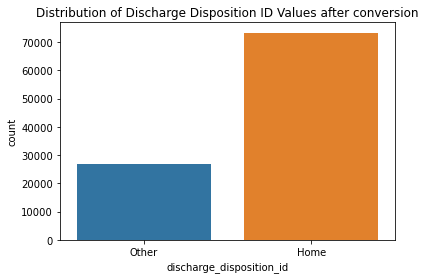

In [34]:
sns.countplot(x ="discharge_disposition_id", data = diabetic_df)
plt.title("Distribution of Discharge Disposition ID Values after conversion")
plt.show()

In [35]:
print("Proportions of ID's")
print(diabetic_df.discharge_disposition_id.value_counts())

Proportions of ID's
Home     73244
Other    26870
Name: discharge_disposition_id, dtype: int64


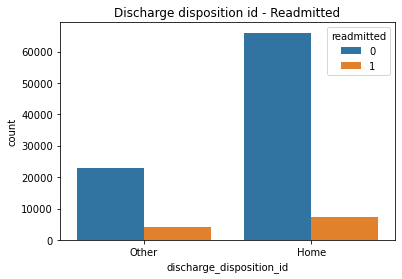

In [36]:
sns.countplot(x ="discharge_disposition_id", hue = "readmitted", data = diabetic_df)
plt.title("Discharge disposition id - Readmitted")
plt.show()

In [37]:
diabetic_df['discharge_disposition_id']

0         Other
1          Home
2          Home
3          Home
4          Home
          ...  
101761    Other
101762    Other
101763     Home
101764    Other
101765     Home
Name: discharge_disposition_id, Length: 100114, dtype: object

##### Admission Source ID

In [38]:
diabetic_df['admission_source_id'].describe()

count    100114.000000
mean          5.738388
std           4.066412
min           1.000000
25%           1.000000
50%           7.000000
75%           7.000000
max          25.000000
Name: admission_source_id, dtype: float64

There are 26 distinct values. This variable will tell whether the patient admitted becuase of physician referral or clinic referral etc

- 1	 Physician Referral
- 2	Clinic Referral
- 3	HMO Referral
- 4	Transfer from a hospital
- 5	 Transfer from a Skilled Nursing Facility (SNF)
- 6	 Transfer from another health care facility
- 7	 Emergency Room
- 8	 Court/Law Enforcement
- 9	 Not Available
- 10	 Transfer from critial access hospital
- 11	Normal Delivery
- 12	 Premature Delivery
- 13	 Sick Baby
- 14	 Extramural Birth
- 15	Not Available
- 17	NULL
- 18	 Transfer From Another Home Health Agency
- 19	Readmission to Same Home Health Agency
- 20	 Not Mapped
- 21	Unknown/Invalid
- 22	 Transfer from hospital inpt/same fac reslt in a sep claim
- 23	 Born inside this hospital
- 24	 Born outside this hospital
- 25	 Transfer from Ambulatory Surgery Center
- 26	Transfer from Hospice


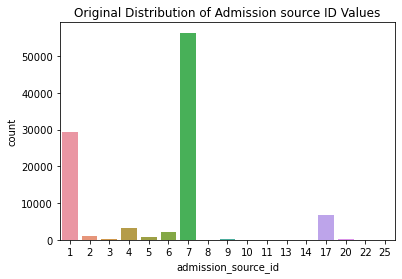

In [39]:
sns.countplot(x ="admission_source_id", data = diabetic_df)
plt.title("Original Distribution of Admission source ID Values")
plt.show()

We can make all observations with respect to admission source into three different categories like, Referral, Emergency or  Other

In [40]:
# map the admission source to three categories
mapped_adm = {1:"Referral",2:"Referral",3:"Referral",
              4:"Other",5:"Other",6:"Other",10:"Other",22:"Other",25:"Other",
              9:"Other",8:"Other",14:"Other",13:"Other",11:"Other",
              15:"Other",17:"Emergency",20:"Referral",21:"Other",
              7:"Emergency"}

# replace the admisision values to three categories
diabetic_df.admission_source_id = diabetic_df.admission_source_id.replace(mapped_adm)

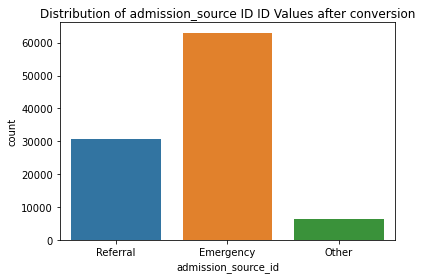

In [41]:
sns.countplot(x = "admission_source_id", data = diabetic_df)
plt.title("Distribution of admission_source ID ID Values after conversion")
plt.show()

In [42]:
print(diabetic_df.admission_source_id.value_counts())

Emergency    63008
Referral     30749
Other         6357
Name: admission_source_id, dtype: int64


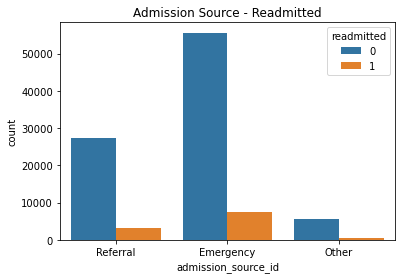

In [43]:
sns.countplot(x = "admission_source_id", hue = "readmitted", data = diabetic_df)
plt.title("Admission Source - Readmitted")
plt.show()

In [44]:
diabetic_df.columns

Index(['admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted',
       'gender', 'age', 'weight', 'race_AfricanAmerican', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Other'],
      dtype='object')

### max_glu_serum column

In [45]:
diabetic_df["max_glu_serum"].unique()

array(['None', '>300', 'Norm', '>200'], dtype=object)

In [46]:
# Get one hot encoding of A1Cresult
one_hot_max_glu_s = pd.get_dummies(diabetic_df["max_glu_serum"], prefix="mgs")
# Drop column diabetic_df as it is now encoded
diabetic_df = diabetic_df.drop('max_glu_serum',axis = 1)
# Join the encoded df
diabetic_df = diabetic_df.join(one_hot_max_glu_s)

### a1c


In [47]:
# Get one hot encoding of A1Cresult
one_hot_a1c = pd.get_dummies(diabetic_df["A1Cresult"], prefix="a1c")
# Drop column diabetic_df as it is now encoded
diabetic_df = diabetic_df.drop('A1Cresult',axis = 1)
# Join the encoded df
diabetic_df = diabetic_df.join(one_hot_a1c)

### number_diagnoses

leaving them as int.

In [48]:
diabetic_df["number_inpatient"].value_counts()

0     66672
1     19163
2      7382
3      3321
4      1588
5       800
6       477
7       264
8       146
9       111
10       59
11       49
12       34
13       18
14       10
15        9
16        6
19        2
17        1
21        1
18        1
Name: number_inpatient, dtype: int64

### num_medications

### number_outpatient         
      


### number_emergency   

### number_inpatient

In [49]:
diabetic_df["glipizide"].value_counts()

No        87509
Steady    11284
Up          767
Down        554
Name: glipizide, dtype: int64

##### time_in_hospital

This is integer variable, this will tell how many days patient stayed in the hospital

In [50]:
diabetic_df['time_in_hospital'].describe()

count    100114.000000
mean          4.389646
std           2.974531
min           1.000000
25%           2.000000
50%           4.000000
75%           6.000000
max          14.000000
Name: time_in_hospital, dtype: float64

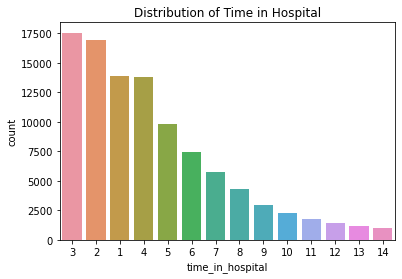

<Figure size 720x576 with 0 Axes>

In [51]:
sns.countplot(x="time_in_hospital", data = diabetic_df,
              order = diabetic_df.time_in_hospital.value_counts().index)
plt.title("Distribution of Time in Hospital")
fig = plt.figure(figsize=(10,8))
plt.show()

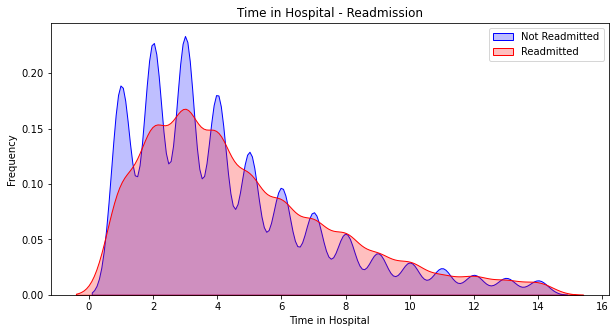

In [52]:
fig = plt.figure(figsize=(10,5))
#readmitted = 0
ax = sns.kdeplot(diabetic_df.loc[(diabetic_df.readmitted == 0), "time_in_hospital"],
                 color = "b", shade = True, label = "Not Readmitted")

ax = sns.kdeplot(diabetic_df.loc[(diabetic_df.readmitted == 1), "time_in_hospital"],
                 color = "r", shade = True, label = "Readmitted")
ax.legend(loc="upper right")

ax.set_xlabel("Time in Hospital")
ax.set_ylabel("Frequency")
ax.set_title("Time in Hospital - Readmission")
plt.show()

##### payer_code 

This is object variable, this variable will tell you the insurance of the patient. This variable has 17 unique values

In [53]:
print(diabetic_df.payer_code.value_counts())

MC    31739
HM     6218
SP     4956
BC     4625
MD     3492
CP     2498
UN     2425
CM     1907
OG     1023
PO      586
DM      546
CH      144
WC      135
OT       94
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64


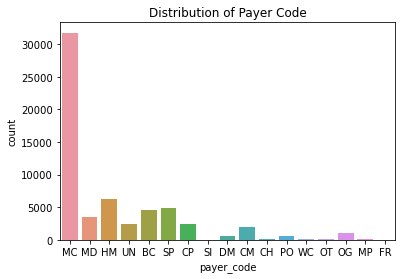

In [54]:
sns.countplot(x = "payer_code", data = diabetic_df)
plt.title("Distribution of Payer Code")
plt.show()

Impute the missing values in payer_code based on frequency 

In [55]:
s = diabetic_df.payer_code.value_counts(normalize=True)
diabetic_df['payer_code_impu'] = diabetic_df['payer_code']
diabetic_df.loc[diabetic_df.payer_code.isna(), 'payer_code_impu'] = np.random.choice(s.index, p=s.values, 
                                                                          size=diabetic_df.payer_code.isna().sum())
diabetic_df

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,race_Other,mgs_>200,mgs_>300,mgs_None,mgs_Norm,a1c_>7,a1c_>8,a1c_None,a1c_Norm,payer_code_impu
0,6,Other,Referral,1,NaN,Pediatrics-Endocrinology,41,0,1,0,...,0.0,0,0,1,0,0,0,1,0,BC
1,1,Home,Emergency,3,NaN,NaN,59,0,18,0,...,0.0,0,0,1,0,0,0,1,0,HM
2,1,Home,Emergency,2,NaN,NaN,11,5,13,2,...,0.0,0,0,1,0,0,0,1,0,MC
3,1,Home,Emergency,2,NaN,NaN,44,1,16,0,...,0.0,0,0,1,0,0,0,1,0,UN
4,1,Home,Emergency,1,NaN,NaN,51,0,8,0,...,0.0,0,0,1,0,0,0,1,0,MC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,Other,Emergency,3,MC,NaN,51,0,16,0,...,0.0,0,0,1,0,0,1,0,0,MC
101762,1,Other,Other,5,MC,NaN,33,3,18,0,...,0.0,0,0,1,0,0,0,1,0,MC
101763,1,Home,Emergency,1,MC,NaN,53,0,9,1,...,0.0,0,0,1,0,0,0,1,0,MC
101764,2,Other,Emergency,10,MC,Surgery-General,45,2,21,0,...,0.0,0,0,1,0,0,0,1,0,MC


In [56]:
diabetic_df.payer_code_impu.isna().sum()

0

In [57]:
print(diabetic_df.payer_code_impu.value_counts())

MC    52491
HM    10292
SP     8132
BC     7629
MD     5775
CP     4107
UN     4059
CM     3204
OG     1719
PO      970
DM      926
CH      227
WC      214
OT      151
MP      129
SI       88
FR        1
Name: payer_code_impu, dtype: int64


##### medical_specialty

This is integer variable, this will tell the specialty of the admitting physician. There are 72 unique values for this variable

In [58]:
print(diabetic_df.medical_specialty.value_counts())

InternalMedicine                    14328
Emergency/Trauma                     7449
Family/GeneralPractice               7302
Cardiology                           5296
Surgery-General                      3068
                                    ...  
Perinatology                            1
Neurophysiology                         1
Psychiatry-Addictive                    1
Pediatrics-InfectiousDiseases           1
Surgery-PlasticwithinHeadandNeck        1
Name: medical_specialty, Length: 72, dtype: int64


In [59]:
# Impute the missing values in medical_specialty based on frequency
m = diabetic_df.medical_specialty.value_counts(normalize=True)
diabetic_df['medical_specialty_impu'] = diabetic_df['medical_specialty']
diabetic_df.loc[diabetic_df.medical_specialty.isna(), 'medical_specialty_impu'] = np.random.choice(m.index, p=m.values, 
                                                                          size=diabetic_df.medical_specialty.isna().sum())
diabetic_df

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,...,mgs_>200,mgs_>300,mgs_None,mgs_Norm,a1c_>7,a1c_>8,a1c_None,a1c_Norm,payer_code_impu,medical_specialty_impu
0,6,Other,Referral,1,NaN,Pediatrics-Endocrinology,41,0,1,0,...,0,0,1,0,0,0,1,0,BC,Pediatrics-Endocrinology
1,1,Home,Emergency,3,NaN,NaN,59,0,18,0,...,0,0,1,0,0,0,1,0,HM,InternalMedicine
2,1,Home,Emergency,2,NaN,NaN,11,5,13,2,...,0,0,1,0,0,0,1,0,MC,Family/GeneralPractice
3,1,Home,Emergency,2,NaN,NaN,44,1,16,0,...,0,0,1,0,0,0,1,0,UN,Emergency/Trauma
4,1,Home,Emergency,1,NaN,NaN,51,0,8,0,...,0,0,1,0,0,0,1,0,MC,Cardiology
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101761,1,Other,Emergency,3,MC,NaN,51,0,16,0,...,0,0,1,0,0,1,0,0,MC,InternalMedicine
101762,1,Other,Other,5,MC,NaN,33,3,18,0,...,0,0,1,0,0,0,1,0,MC,InternalMedicine
101763,1,Home,Emergency,1,MC,NaN,53,0,9,1,...,0,0,1,0,0,0,1,0,MC,InternalMedicine
101764,2,Other,Emergency,10,MC,Surgery-General,45,2,21,0,...,0,0,1,0,0,0,1,0,MC,Surgery-General


In [60]:
print(diabetic_df.medical_specialty_impu.value_counts())

InternalMedicine                    28269
Emergency/Trauma                    14561
Family/GeneralPractice              14214
Cardiology                          10418
Surgery-General                      6022
                                    ...  
Neurophysiology                         3
Surgery-PlasticwithinHeadandNeck        2
SportsMedicine                          2
Psychiatry-Addictive                    1
Pediatrics-InfectiousDiseases           1
Name: medical_specialty_impu, Length: 72, dtype: int64


We can convert all these observations with respect to medical_specialty into 9 or 10 different categories  

In [61]:
top_10=['InternalMedicine','Family/GeneralPractice','Cardiology','Surgery-General',
        "Nephrology","Orthopedics","Radiologist","Pulmonology"]

diabetic_df.loc[~diabetic_df['medical_specialty_impu'].isin(top_10),'medical_specialty_impu']='Other'

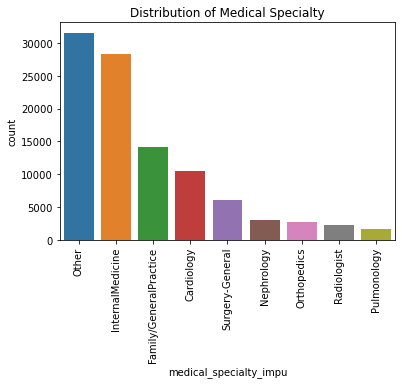

In [62]:
sns.countplot(x = "medical_specialty_impu", data = diabetic_df)
plt.title("Distribution of Medical Specialty")
plt.xticks(rotation = 90)
plt.show()

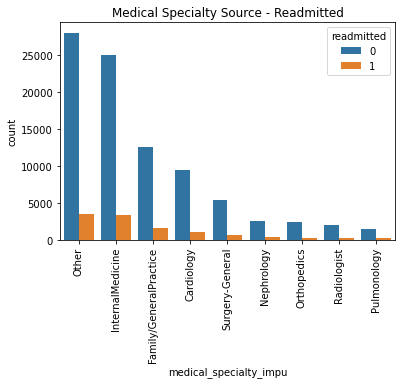

In [63]:
sns.countplot(x = "medical_specialty_impu",hue = "readmitted", data = diabetic_df)
plt.title("Medical Specialty Source - Readmitted")
plt.xticks(rotation = 90)
plt.show()

##### num_lab_procedures

This is integer and this will tell number of lab tests performed during hospital stay

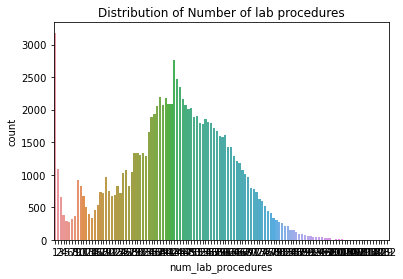

In [64]:
sns.countplot(x = "num_lab_procedures", data = diabetic_df)
plt.title("Distribution of Number of lab procedures")
plt.show()

In [65]:
print("Proportions of Column")
print(diabetic_df.num_lab_procedures.value_counts().head(10))

Proportions of Column
1     3180
43    2765
44    2467
45    2347
38    2191
40    2183
46    2157
41    2091
42    2082
47    2076
Name: num_lab_procedures, dtype: int64


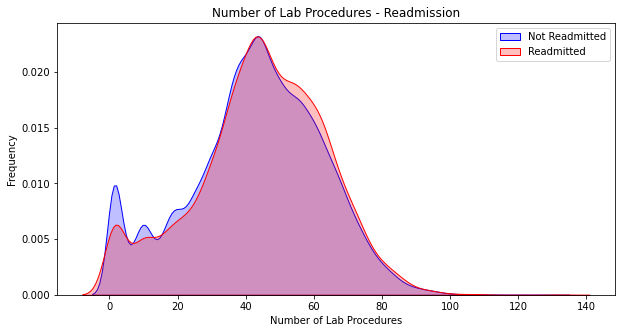

In [66]:
fig = plt.figure(figsize=(10,5))

#readmitted = 0
ax = sns.kdeplot(diabetic_df.loc[(diabetic_df.readmitted == 0), "num_lab_procedures"],
                 color = "b", shade = True,label = "Not Readmitted")

#readmitted = 1
ax = sns.kdeplot(diabetic_df.loc[(diabetic_df.readmitted == 1), "num_lab_procedures"],
                 color = "r", shade = True, label = "Readmitted")

ax.legend(loc="upper right")

ax.set_xlabel("Number of Lab Procedures")
ax.set_ylabel("Frequency")
ax.set_title("Number of Lab Procedures - Readmission")

plt.show()

##### num_procedures

Number of procedures (other than lab tests) performed during the encounter

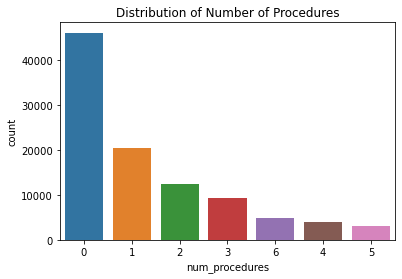

In [67]:
sns.countplot(x = diabetic_df.num_procedures, order = diabetic_df.num_procedures.value_counts().index)
plt.title("Distribution of Number of Procedures")
plt.show()

In [68]:
print("Proportions of Values")
print(diabetic_df.num_procedures.value_counts())

Proportions of Values
0    46090
1    20441
2    12461
3     9246
6     4811
4     4068
5     2997
Name: num_procedures, dtype: int64


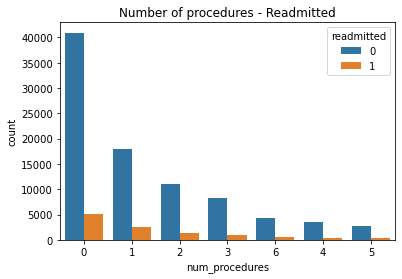

In [69]:
sns.countplot(x = "num_procedures", hue = "readmitted", 
              data = diabetic_df, order = diabetic_df.num_procedures.value_counts().index)
plt.title("Number of procedures - Readmitted")
plt.show()

#####  glipizide                 

In [70]:
print(diabetic_df.glipizide.value_counts())
print(diabetic_df.glyburide.value_counts())
print(diabetic_df.tolbutamide.value_counts())
print(diabetic_df.pioglitazone.value_counts())
print(diabetic_df.rosiglitazone.value_counts())
print(diabetic_df.acarbose.value_counts())
print(diabetic_df.miglitol.value_counts())
print(diabetic_df.troglitazone.value_counts())
print(diabetic_df.tolazamide.value_counts())
print(diabetic_df.examide.value_counts())

No        87509
Steady    11284
Up          767
Down        554
Name: glipizide, dtype: int64
No        89547
Steady     9200
Up          806
Down        561
Name: glyburide, dtype: int64
No        100093
Steady        21
Name: tolbutamide, dtype: int64
No        92833
Steady     6934
Up          230
Down        117
Name: pioglitazone, dtype: int64
No        93785
Steady     6070
Up          173
Down         86
Name: rosiglitazone, dtype: int64
No        99807
Steady      294
Up           10
Down          3
Name: acarbose, dtype: int64
No        100076
Steady        31
Down           5
Up             2
Name: miglitol, dtype: int64
No        100111
Steady         3
Name: troglitazone, dtype: int64
No        100075
Steady        38
Up             1
Name: tolazamide, dtype: int64
No    100114
Name: examide, dtype: int64


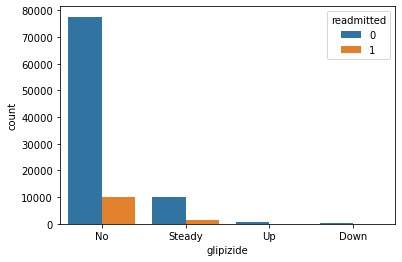

GLIPIZIDE
No        87509
Steady    11284
Up          767
Down        554
Name: glipizide, dtype: int64


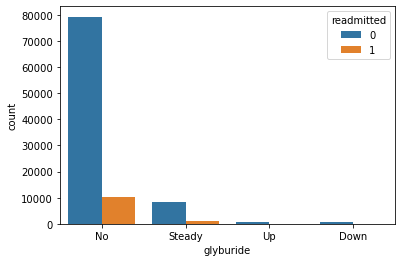

GLYBURIDE
No        89547
Steady     9200
Up          806
Down        561
Name: glyburide, dtype: int64


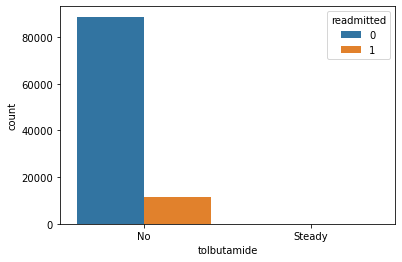

TOLBUTAMIDE
No        100093
Steady        21
Name: tolbutamide, dtype: int64


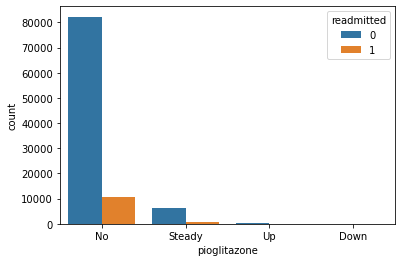

PIOGLITAZONE
No        92833
Steady     6934
Up          230
Down        117
Name: pioglitazone, dtype: int64


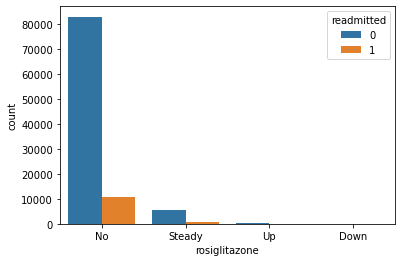

ROSIGLITAZONE
No        93785
Steady     6070
Up          173
Down         86
Name: rosiglitazone, dtype: int64


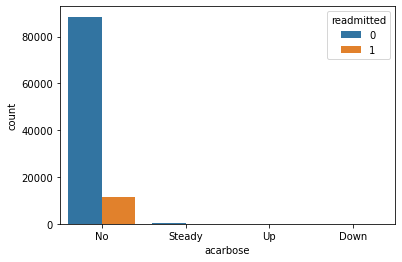

ACARBOSE
No        99807
Steady      294
Up           10
Down          3
Name: acarbose, dtype: int64


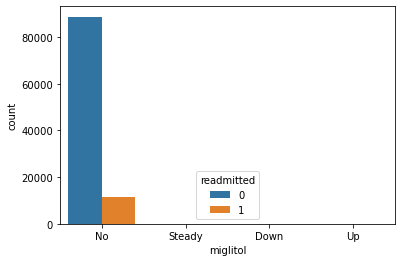

MIGLITOL
No        100076
Steady        31
Down           5
Up             2
Name: miglitol, dtype: int64


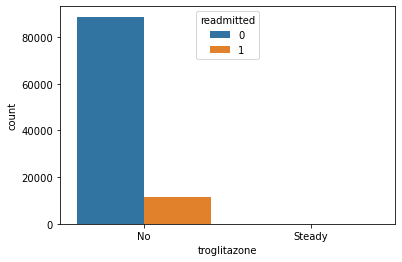

TROGLITAZONE
No        100111
Steady         3
Name: troglitazone, dtype: int64


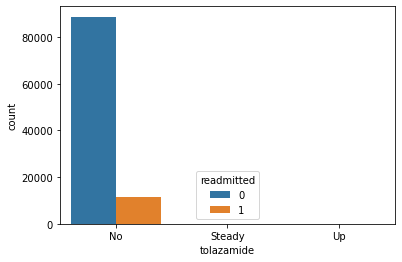

TOLAZAMIDE
No        100075
Steady        38
Up             1
Name: tolazamide, dtype: int64


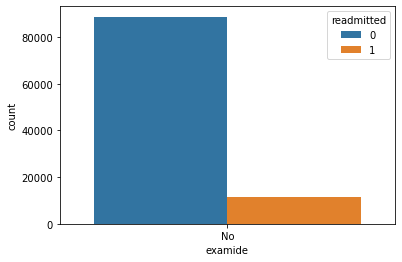

EXAMIDE
No    100114
Name: examide, dtype: int64


In [71]:
drug_cols = ['glipizide', 'glyburide', 'tolbutamide',
             'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
             'tolazamide', 'examide']

def explore_drug(drugs):

    for drug in drugs:
        sns.countplot(x = drug, hue = "readmitted", data = diabetic_df)
        plt.show()
        print(drug.upper())
        print(diabetic_df[f"{drug}"].value_counts())
    

explore_drug(drug_cols)

In [72]:
# convert diag_ variables to Categorize based on https://www.hindawi.com/journals/bmri/2014/781670/tab2/
def convert_diag(code):
    try:
        code = float(code)
    except:
        code = 0

    # Circulatory
    if code in range(390,460) or code == 785:
        return("Circulatory")

    # Respiratory
    elif code in range(460,520) or code == 786:
        return("Respiratory")

    # Digestive
    elif code in range(520,580) or code == 787:
        return("Digestive")

    # Diabetes
    elif code >= 250 and code < 251:
        return("Diabetes")

    # Injury
    elif code in range(800,1000):
        return("Injury")

    # Musculoskeletal
    elif code in range(710,740):
        return("Musculoskeletal")

    # Genitourinary
    elif code in range(580,630) or code == 788:
        return("Genitourinary")

    # Neoplasms
    elif code in range(140,240):
        return("Neoplasms")
    elif code in range(780,783) or code == 784:
        return("Neoplasms")
    elif code in range(790,800):
        return("Neoplasms")
    elif code in range(240,250):
        return("Neoplasms")
    elif code in range(251,280):
        return("Neoplasms")
    elif code in range(680,710):
        return("Neoplasms")
    elif code in range(1,140):
        return("Neoplasms")
    elif code in range(290,320):
        return("Neoplasms")

    # Other
    else:
        return("Other")

In [73]:
diabetic_df["Diag1"] = diabetic_df["diag_1"].apply(convert_diag)
diabetic_df["Diag2"] = diabetic_df["diag_2"].apply(convert_diag)
diabetic_df["Diag3"] = diabetic_df["diag_3"].apply(convert_diag)

In [74]:
diabetic_df = diabetic_df.drop(columns=['diag_1', 'diag_2', 'diag_3'])

In [75]:
#balaji_df = diabetic_df[balaji_cols]

df = diabetic_df

In [76]:
## removing variables "payer_code" and "medical_specialty" with large number of missing values and also not going to impact 
## target "readmitted"

df = df.drop(['payer_code', 'medical_specialty'], axis = 1)

In [77]:
## remove all variables with less than 6 percentage variance

#balaji_df = balaji_df.drop(['examide', 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone',
#                               'acarbose', 'miglitol', 'troglitazone', ], axis = 1)

In [78]:
df.head()

,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,...,mgs_Norm,a1c_>7,a1c_>8,a1c_None,a1c_Norm,payer_code_impu,medical_specialty_impu,Diag1,Diag2,Diag3
0,6,Other,Referral,1,41,0,1,0,0,0,...,0,0,0,1,0,BC,Other,Diabetes,Other,Other
1,1,Home,Emergency,3,59,0,18,0,0,0,...,0,0,0,1,0,HM,InternalMedicine,Neoplasms,Diabetes,Neoplasms
2,1,Home,Emergency,2,11,5,13,2,0,1,...,0,0,0,1,0,MC,Family/GeneralPractice,Other,Diabetes,Other
3,1,Home,Emergency,2,44,1,16,0,0,0,...,0,0,0,1,0,UN,Other,Neoplasms,Diabetes,Circulatory
4,1,Home,Emergency,1,51,0,8,0,0,0,...,0,0,0,1,0,MC,Cardiology,Neoplasms,Neoplasms,Diabetes


Convert the categorical variables using onehot encoding


In [79]:
df_cleaned = pd.get_dummies(df, columns=['discharge_disposition_id', 'admission_source_id', 'payer_code_impu', 
                                                       'medical_specialty_impu', 'Diag1','Diag2','Diag3',
                                                       "metformin", "repaglinide", "nateglinide", "chlorpropamide", 
                                                       "glimepiride", "acetohexamide", "glipizide", "glyburide", 
                                                       "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", 
                                                       "miglitol", "troglitazone", "tolazamide", "examide", 
                                                       "citoglipton", "insulin", "glyburide-metformin", 
                                                       "glipizide-metformin", "glimepiride-pioglitazone", 
                                                       "metformin-rosiglitazone", "metformin-pioglitazone", 
                                                       "change", "diabetesMed"],
                        prefix=["Discharged_to", "Admission_source","payer_code", "medical_specialty", "Diag1","Diag2",
                                "Diag3", "metformin", "repaglinide", "nateglinide", "chlorpropamide", 
                                "glimepiride", "acetohexamide", "glipizide", "glyburide", 
                                "tolbutamide", "pioglitazone", "rosiglitazone", "acarbose", 
                                "miglitol", "troglitazone", "tolazamide","examide", 
                                "citoglipton", "insulin", "glyburide-metformin", 
                                "glipizide-metformin","glimepiride-pioglitazone", 
                                "metformin-rosiglitazone", "metformin-pioglitazone", 
                                "change", "diabetesMed"] )

In [80]:
df_cleaned.columns

Index(['admission_type_id', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'readmitted',
       ...
       'glimepiride-pioglitazone_No', 'glimepiride-pioglitazone_Steady',
       'metformin-rosiglitazone_No', 'metformin-rosiglitazone_Steady',
       'metformin-pioglitazone_No', 'metformin-pioglitazone_Steady',
       'change_Ch', 'change_No', 'diabetesMed_No', 'diabetesMed_Yes'],
      dtype='object', length=159)

In [81]:
# Create X (Independent variables) and y(target) from the dataframe with all variables
X = df_cleaned.drop(['readmitted'],axis=1)
ind_columns = df_cleaned.drop('readmitted',axis=1).columns
y = df_cleaned['readmitted']

In [82]:
pd.set_option('display.max_rows', 200)
print(X.dtypes)

admission_type_id                             int64
time_in_hospital                              int64
num_lab_procedures                            int64
num_procedures                                int64
num_medications                               int64
number_outpatient                             int64
number_emergency                              int64
number_inpatient                              int64
number_diagnoses                              int64
gender                                        int64
age                                           int64
weight                                      float64
race_AfricanAmerican                        float64
race_Asian                                  float64
race_Caucasian                              float64
race_Hispanic                               float64
race_Other                                  float64
mgs_>200                                      uint8
mgs_>300                                      uint8
mgs_None    

We did normalize the attributes using StandardScaler() to scale them between 0 and 1 before running models.

In [83]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

We chose a stratified k-fold validation algorithm. In stratified k-fold cross-validation, the original sample is randomly partitioned into k equal size subsamples in which each fold contains roughly the same proportions of class labels. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k-1 subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged (or otherwise combined) to produce a single estimation. The advantage of this method is that all observations are used for both training and validation, and each observation is used for validation exactly once.

The typical standard of 10 folds will be adequate for this dataset

In [84]:
#Create Cross Validation Procedure
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

#### Model 1: Logistic regression

For our classification model we will initially track the accuracy, precision, and recall of the model as they are built. The precision for our classification model represents the ratio of the patients that the model correctly identifies as a positive readmission out of all the patients the model identifies as positive. The recall (also referred to as sensitivity), represents the ability of the model to correctly identify true positive readmission. The accuracy represents how well the model classifies correctly both positive and negative readmission. 


In [85]:
# Model Metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

def displayModel_metrics(best_model, grid_model, features, target, cv):
    metrics = cross_validate(best_model, features, y=target, cv=cv, 
                             scoring=['accuracy','precision','recall'], return_train_score=True) 
    
    y_predict = cross_val_predict(best_model, features, target, cv=cv)

    print('\nBest Accuracy with Grid Search            : {:.3f}'.format(grid_model.best_score_))
    print('\nTraining data Metrics')
    print('\n     The average accuraccy : {:.3f}'.format(metrics['train_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['train_precision'].mean()))
    print('     The average recall    : {:.3f}'.format(metrics['train_recall'].mean()))

    print('\nTest data Metrics')
    print('\n     The average accuracy  : {:.3f}'.format(metrics['test_accuracy'].mean()))
    print('     The average precision : {:.3f}'.format(metrics['test_precision'].mean()))
    print('     The average  recall   : {:.3f}'.format(metrics['test_recall'].mean()))
    
    matrix = classification_report(target, y_predict, labels=[1,0])
    print('\nClassification report\n')
    print(matrix)

In [86]:
# Reference https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb
# ROC curve plot
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn import metrics as mt

def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

GridSearch Parameters:

penalty: Used to specify the norm used in the penalization.  

C: Inverse of regularization strength

max_iter: Maximum number of iterations taken for the solvers to converge. 

class_weight: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to 
class frequencies in the input data .

solver:Algorithm to use in the optimization problem

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()

# define parameters

penalty_LR = ['l1', 'l2', 'elasticnet', 'none'] 

C_LR = [0.001, 0.01, 0.1, 1, 10, 100, 1000]  

max_iter_LR = [500, 1000]

class_weight_LR = ['balanced']

solver_LR = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# define grid search
param_grid_LR = dict(penalty=penalty_LR, C=C_LR, max_iter=max_iter_LR, class_weight=class_weight_LR, solver=solver_LR)

grid_search_LR = GridSearchCV(estimator=LR, param_grid=param_grid_LR, n_jobs=7, cv=cv, 
                              scoring='accuracy',error_score=0)

In [88]:
%%time
grid_result_LR = grid_search_LR.fit(X_scaled, y)
# summarize results
print("Best: %f using %s" % (grid_result_LR.best_score_, grid_result_LR.best_params_))
means = grid_result_LR.cv_results_['mean_test_score']
stds = grid_result_LR.cv_results_['std_test_score']
params = grid_result_LR.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1483: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/ravis/miniforge3/lib/python3.9/site-packages/sklearn/linea

Best: 0.662694 using {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'lbfgs'}
0.623829 (0.003042) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'sag'}
0.662694 (0.002832) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'solver': 'saga'}
0.653535 (0.002894) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}
0.653505 (0.002873) with: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'solver': 'lbfgs'}
0.651307 (0.002909) with: {'C': 0.001

In [89]:
# 
results_LR = pd.DataFrame(grid_result_LR.cv_results_['params'])
results_LR['test_score'] = grid_result_LR.cv_results_['mean_test_score']
results_LR 

,C,class_weight,max_iter,penalty,solver,test_score
0,0.001,balanced,500,l1,newton-cg,0.000000
1,0.001,balanced,500,l1,lbfgs,0.000000
2,0.001,balanced,500,l1,liblinear,0.623829
3,0.001,balanced,500,l1,sag,0.000000
4,0.001,balanced,500,l1,saga,0.662694
...,...,...,...,...,...,...
275,1000.000,balanced,1000,none,newton-cg,0.653625
276,1000.000,balanced,1000,none,lbfgs,0.653615
277,1000.000,balanced,1000,none,liblinear,0.000000
278,1000.000,balanced,1000,none,sag,0.653625


In [90]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_LR =grid_result_LR.best_estimator_
best_Estimator_LR

LogisticRegression(C=0.001, class_weight='balanced', max_iter=500, penalty='l1',
                   solver='saga')

In [91]:
# Display model metrics
displayModel_metrics(best_Estimator_LR, grid_result_LR, X_scaled, y, cv)


Best Accuracy with Grid Search            : 0.663

Training data Metrics

     The average accuraccy : 0.663
     The average precision : 0.176
     The average recall    : 0.534

Test data Metrics

     The average accuracy  : 0.663
     The average precision : 0.176
     The average  recall   : 0.535

Classification report

              precision    recall  f1-score   support

           1       0.18      0.54      0.26     11357
           0       0.92      0.68      0.78     88757

    accuracy                           0.66    100114
   macro avg       0.55      0.61      0.52    100114
weighted avg       0.84      0.66      0.72    100114



#### Plot ROC

The ROC curve shows the relationship between the model's ability to correctly vs incorrectly classify if readmmited or not with in 30 days. We could potentially make adjustments that could shift the ROC curve to have a higher true positive rate at the expense of increasing the false positive rate.

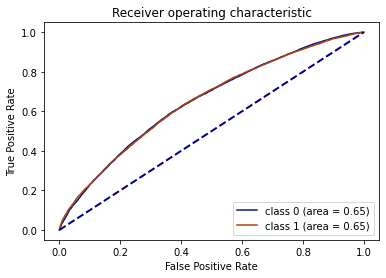

In [92]:
# Plot ROC curve
roc_curve_plot(grid_result_LR, X_scaled, y)

The ROC curve for the logistic regression classifier showed a mean area under the curve AUC of 0.66.

#### Learning Curves for Classifiers

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

In [93]:
from yellowbrick.model_selection import LearningCurve

def Learning_curve_plot(model):
    # Create the learning curve visualizer
    sizes = np.linspace(0.3, 1.0, 10)
    
    visualizer = LearningCurve(
    model, cv=cv, scoring='accuracy', train_sizes=sizes, n_jobs=-1)

    visualizer.fit(X_scaled, y)        # Fit the data to the visualizer
    visualizer.show()           # Finalize and render the figure

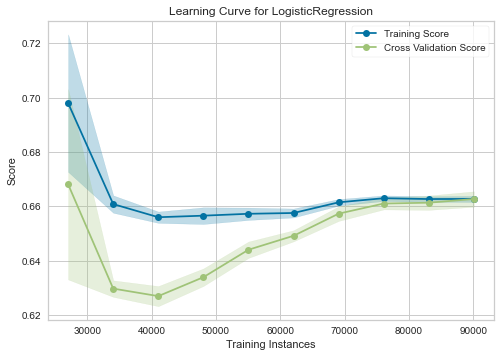

In [94]:
# Learning curve for LR classifier
Learning_curve_plot(best_Estimator_LR)

With Logistic regression classifier, the training score and the validation score are converging with more data. With increasing training data, the validation score standard deviation is also changing a little which suggests logistic regression classifier  will overfit with more data.

### Identify Important Features

In [95]:
feature_importance_df = pd.DataFrame(ind_columns, columns=['features'])
feature_importance_df['feature_coef'] = best_Estimator_LR.coef_[0]

feature_importance_df.head()
feature_importance_df = feature_importance_df.sort_values(by=['feature_coef'])

The features leading to higher readmittance within 30 days are (those with positive co-efficients) and the features that reduce the chance of readmittance within 30 days (thos with negative co-efficients) are the most signficant features. 



In [115]:
feature_importance_df.loc[feature_importance_df['feature_coef'] != 0].sort_values(by='feature_coef', ascending=True )

,features,feature_coef
25,Discharged_to_Home,-0.088361
64,Diag1_Respiratory,-0.022072
156,diabetesMed_No,-0.013376
139,insulin_No,-0.010145
56,Diag1_Circulatory,0.001348
84,metformin_No,0.002332
4,num_medications,0.013085
10,age,0.013088
157,diabetesMed_Yes,0.013376
138,insulin_Down,0.017380


Text(0, 0.5, 'Features')

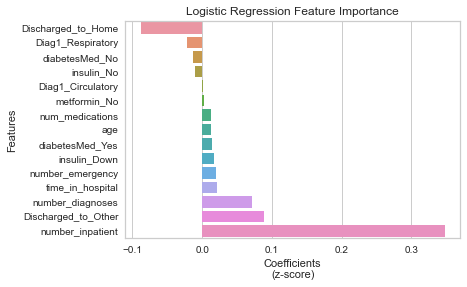

In [116]:
important_features = feature_importance_df.loc[feature_importance_df['feature_coef'] != 0]

ax = sns.barplot(x ='feature_coef', y = 'features', data=important_features, orient= 'h')
ax.set_title("Logistic Regression Feature Importance")
ax.set_xlabel("Coefficients\n(z-score)")
ax.set_ylabel("Features")

The bottom 10 features potentially show us those features that are most likely to decrease the chance of readmission. Having diabetic medication prescribed as "No" along with being primary and secondary diagnosis is Respiratory perhaps reduces the chance of readmission.

In [119]:
print(important_features)

                features  feature_coef
25    Discharged_to_Home     -0.088361
64     Diag1_Respiratory     -0.022072
156       diabetesMed_No     -0.013376
139           insulin_No     -0.010145
56     Diag1_Circulatory      0.001348
84          metformin_No      0.002332
4        num_medications      0.013085
10                   age      0.013088
157      diabetesMed_Yes      0.013376
138         insulin_Down      0.017380
6       number_emergency      0.019839
1       time_in_hospital      0.021283
8       number_diagnoses      0.071881
26   Discharged_to_Other      0.088361
7       number_inpatient      0.348032
